# Eggplant Regression Model with SARIMA
By Menard Gymer Rivera

## Load the Dataset

In [51]:
import pandas as pd

In [52]:
Tilapia_UN = pd.read_excel('./data/eggplant_UN.xlsx')

In [53]:
Tilapia_DA = pd.read_excel('./data/eggplant_DA.xlsx')

In [54]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,434,Eggplants - Retail,5,KG,5,2020,64.69
1,434,Eggplants - Retail,5,KG,5,2020,40.00
2,434,Eggplants - Retail,5,KG,5,2020,57.89
3,434,Eggplants - Retail,5,KG,5,2020,60.95
4,434,Eggplants - Retail,5,KG,5,2020,78.80
...,...,...,...,...,...,...,...
1169,434,Eggplants - Retail,5,KG,6,2021,61.25
1170,434,Eggplants - Retail,5,KG,6,2021,48.13
1171,434,Eggplants - Retail,5,KG,6,2021,51.25
1172,434,Eggplants - Retail,5,KG,6,2021,87.50


In [55]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Eggplants - Retail,NaN,KG,1,2022,80.163679
1,NaN,Eggplants - Retail,NaN,KG,2,2022,67.253363
2,NaN,Eggplants - Retail,NaN,KG,3,2022,65.833898
3,NaN,Eggplants - Retail,NaN,KG,4,2022,68.819387
4,NaN,Eggplants - Retail,NaN,KG,5,2022,69.977679


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [56]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [57]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [58]:
Tilapia_UN.head()

,mp_price,date
0,64.69,2020-05-15
1,40.00,2020-05-15
2,57.89,2020-05-15
3,60.95,2020-05-15
4,78.80,2020-05-15


### DA Bantay Presyo

In [59]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [60]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id','cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [61]:
Tilapia_DA.head()

,mp_price,date
0,80.163679,2022-01-15
1,67.253363,2022-02-15
2,65.833898,2022-03-15
3,68.819387,2022-04-15
4,69.977679,2022-05-15


In [62]:
import matplotlib.pyplot as plt

In [63]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

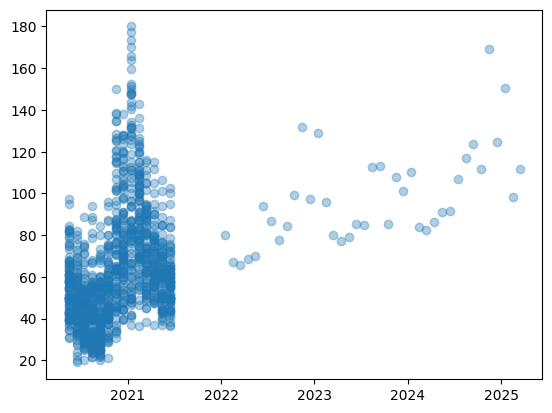

<Figure size 5000x600 with 0 Axes>

In [64]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [65]:
from datetime import datetime

In [66]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [67]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [68]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [69]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2020-05-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [70]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

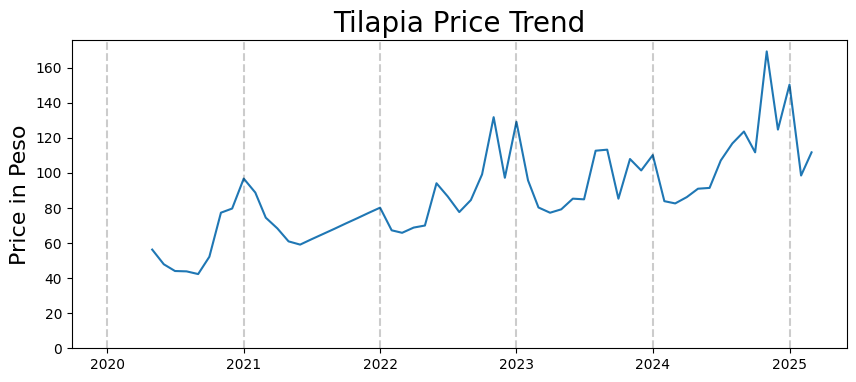

In [71]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [72]:
first_diff = lim_tilapia.diff()[1:]

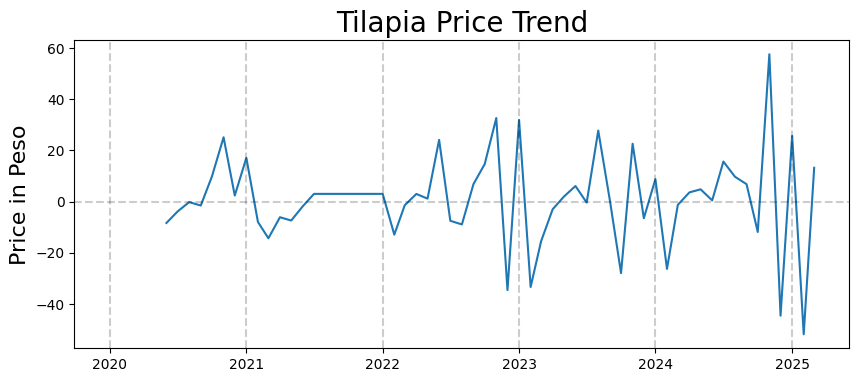

In [73]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [74]:
from statsmodels.tsa.stattools import acf, pacf

In [75]:
first_diff.columns

Index(['mp_price'], dtype='object')

In [76]:
first_diff.head()

,mp_price
date,
2020-06-01,-8.367600
2020-07-01,-3.845023
2020-08-01,-0.203697
2020-09-01,-1.535106
2020-10-01,9.865992


<BarContainer object of 18 artists>

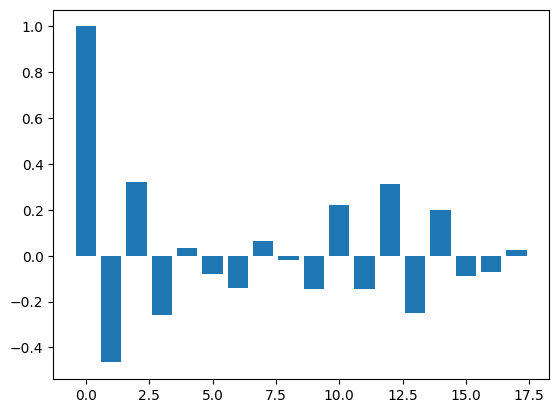

In [77]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

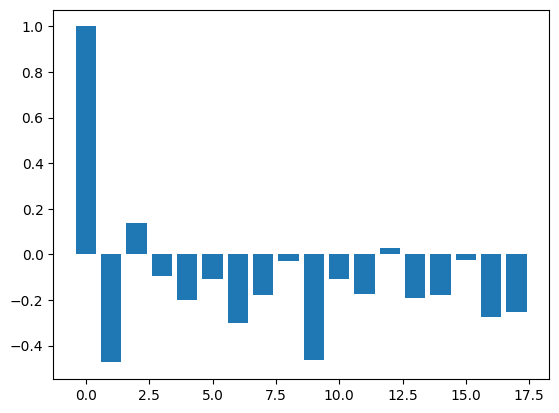

In [78]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [79]:
from datetime import timedelta

In [80]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [81]:
Tilapia.describe()

,mp_price
count,59.000000
mean,87.181361
std,25.694732
min,42.311557
25%,69.398533
50%,84.504280
75%,100.264549
max,169.250000


## Fit the SARIMA Model

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [83]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [84]:
from time import time

In [85]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 9.553752660751343


In [86]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -208.820
Date:                              Wed, 21 May 2025   AIC                            423.641
Time:                                      01:39:18   BIC                            429.494
Sample:                                  05-01-2020   HQIC                           425.885
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9978      0.576      1.731      0.083      -0.132       2.127
ma.S.L12      -0.95

In [87]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    111.71
2024-11-01    169.25
2024-12-01    124.67
2025-01-01    150.33
2025-02-01     98.50


In [88]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [89]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [90]:
predictions

date
2024-10-01    123.432878
2024-11-01    137.468218
2024-12-01    131.433376
2025-01-01    141.648542
2025-02-01    128.069648
2025-03-01    122.618298
Freq: MS, Name: predicted_mean, dtype: float64

In [91]:
residuals

date
2024-10-01   -11.722878
2024-11-01    31.781782
2024-12-01    -6.763376
2025-01-01     8.681458
2025-02-01   -29.569648
2025-03-01   -10.918298
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

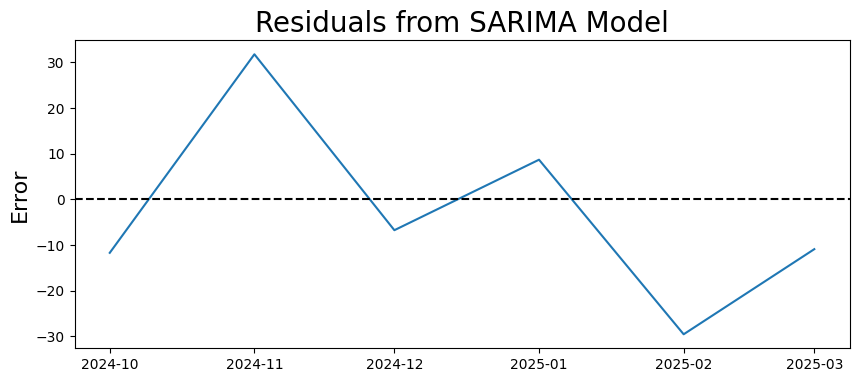

In [92]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

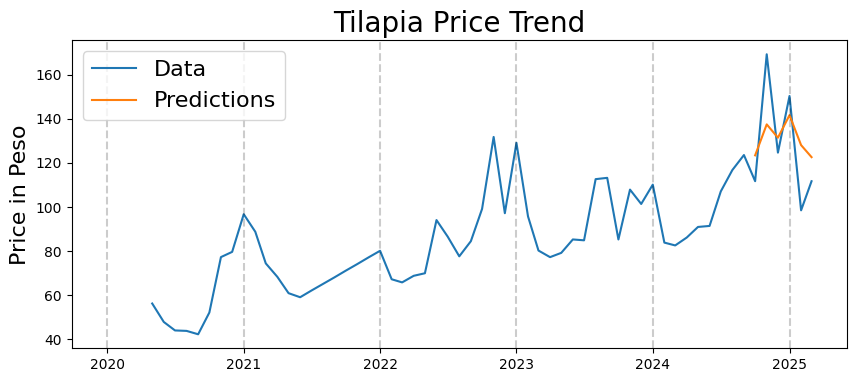

In [93]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [94]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data['mp_price'], order=my_order, seasonal_order=my_seasonal_order)

    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipykernel_63308/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_63308/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_63308/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_63308/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/meg/jupyter_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-inve

In [95]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

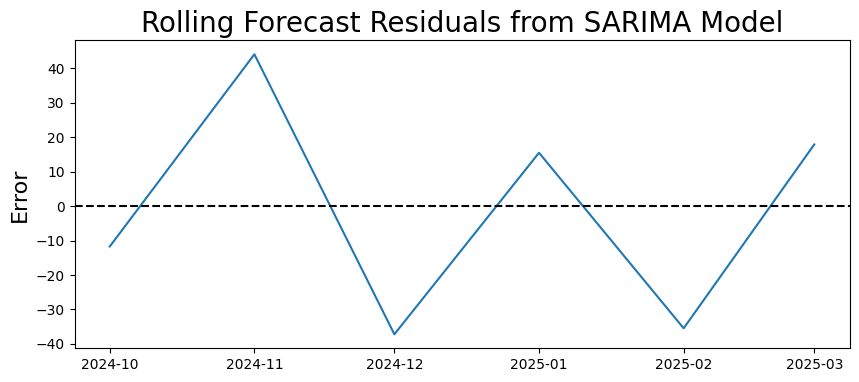

In [96]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

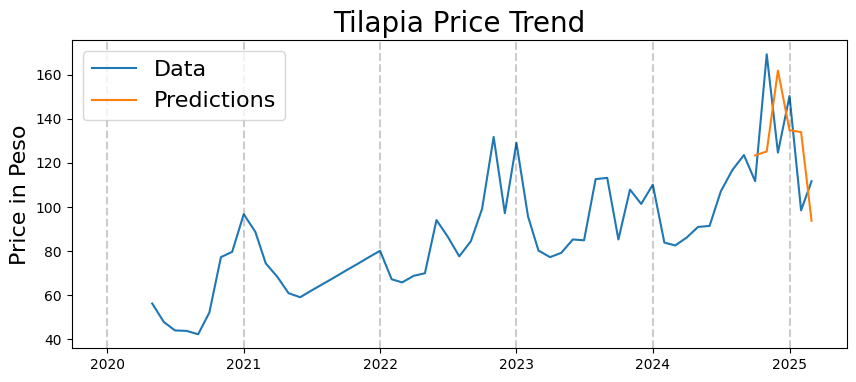

In [97]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [98]:
import numpy as np

In [99]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.2145


In [100]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 29.669833991364705


## Future Predictions (2025)

# eefe 